# Setup

In [2]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np

# In[2]:
dataset_path = './dataset'

# 3:color or 1:grayscale
depth = 3
image_size_y = 80
image_size_x = 80

image_data = []
image_class = []


# In[3]:


for i, dir in enumerate(os.listdir(dataset_path)):
    class_dir = (dataset_path + '/' + dir)
    for image in os.listdir(class_dir):
        image_file = class_dir + '/' + image
        img = cv2.imread(image_file)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        res = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_CUBIC)
        image_data.append(res)
        image_class.append((i - 1) * -1)
        
image_data = np.array(image_data, dtype='float32')
image_class = np.array(image_class, dtype='float64')


# In[4]:


train_image, test_image, train_label, test_label = train_test_split(image_data,
                                                                    image_class,
                                                                    test_size=0.2)

In [3]:
# In[5]:

import pickle

file = open('test_data.pkl', 'wb')
test_set = (test_image, test_label)
pickle.dump(test_set, file)
file.close()

file = open('train_data.pkl', 'wb')
train_set = (train_image, train_label)
pickle.dump(train_set, file)
file.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from tensorflow.keras.utils import plot_model
import os

file = open('test_data.pkl', 'rb')
test_image, test_label = pickle.load(file)
file.close()

file = open('train_data.pkl', 'rb')
train_image, train_label = pickle.load(file)
file.close()

train_image = train_image.reshape(len(train_image), image_size_x, image_size_y, depth)
train_image = train_image / 255.0

test_image = test_image.reshape(len(test_image), image_size_x, image_size_y, depth)
test_image = test_image / 255.0

In [4]:
now = datetime.now()
dt_string = now.strftime("%d%m%Y-%H%M")

name = dt_string

foldername = './models/' + name + '/'
os.mkdir(foldername)

In [5]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, test_data, max_loss_to_save):
        self.test_data = test_data
        self.min_loss = 99.99
        self.max_acc = -1
        self.counter = 0
        self.max_loss_to_save = max_loss_to_save

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

        if acc > self.max_acc:
            self.max_acc = acc

        if loss < self.min_loss:
            self.min_loss = loss

            if loss < self.max_loss_to_save:
                mnow = datetime.now()
                mdt_string = mnow.strftime("%d%m%Y-%H%M")

                mname = 'l{:4.0f}-a{:2.0f}-'.format(loss*10000, acc*100) + dt_string

                filename = foldername + mname

                print('Saving model as {}...\n\n'.format(filename))
                plot_model(model, to_file=(filename+'.png'), show_shapes=True)
                model.save(filename+'.h5')

        if loss > self.min_loss:
            self.counter += 1

            if self.counter > 15 or loss > 0.65:
                print('Model hasn\'t improved in a while, cancelling training')
                self.model.stop_training = True

    def on_train_end(self, logs={}):
        print('\n\n\nSUMMARRY')
        print('========')
        print('Best loss: {}, Best Acc: {}'.format(self.min_loss, self.max_acc))

In [6]:
image_data.shape

(8086, 80, 80, 3)

0.0
(80, 80, 3)


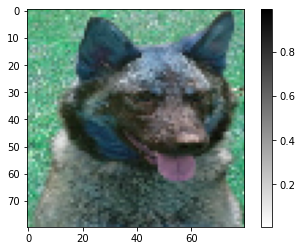

In [7]:
n = 1
img = train_image[n]
print(train_label[n])
print(img.shape)

plt.figure()
plt.imshow(img, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Defining CNN Model

In [8]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu,
                            input_shape=(image_size_x, image_size_y, depth)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.MaxPool2D(2, 2),
    #tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(2, 2),
    #tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(2, 2),
    #tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                #loss='binary_crossentropy',
                metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 24336)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                778784    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 779,298
Trainable params: 779,298
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_image, train_label, epochs=12, 
          validation_split=0.25, shuffle=True,
          callbacks=[CustomModelCheckpoint((test_image, test_label), 0.2406127)],
                   verbose=1)

test_loss = model.evaluate(test_image, test_label)

Epoch 1/12
152/152 [==============================] - 6s 39ms/step - loss: 0.7589 - acc: 0.6418 - val_loss: 0.4449 - val_acc: 0.7978

Testing loss: 0.44190508127212524, acc: 0.7911001443862915

Epoch 2/12
152/152 [==============================] - 6s 37ms/step - loss: 0.4243 - acc: 0.7936 - val_loss: 0.4147 - val_acc: 0.7978

Testing loss: 0.41310498118400574, acc: 0.8065512776374817

Epoch 3/12
152/152 [==============================] - 6s 37ms/step - loss: 0.3417 - acc: 0.8417 - val_loss: 0.4175 - val_acc: 0.8089

Testing loss: 0.41100844740867615, acc: 0.8139678835868835

Epoch 4/12
152/152 [==============================] - 6s 37ms/step - loss: 0.2832 - acc: 0.8723 - val_loss: 0.4534 - val_acc: 0.8015

Testing loss: 0.43902233242988586, acc: 0.8003708124160767

Epoch 5/12
152/152 [==============================] - 6s 36ms/step - loss: 0.2243 - acc: 0.9083 - val_loss: 0.4491 - val_acc: 0.7897

Testing loss: 0.44933897256851196, acc: 0.7904821038246155

Epoch 6/12
152/152 [==========

In [10]:
def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices((test_image)).batch(1).take(1000):
        yield [tf.dtypes.cast(data, tf.float32)]
        
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

# Save the model.
with open('modelV8.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Nikita\AppData\Local\Temp\tmpwmj9w27u\assets
